# MNIST digit classification

### This is a multiclass classification problem where we want to predict the classes 0 to 9

* Three different learning algorithms will be trained and compared against each other.

* Evaluation metric is accuracy
  
* We're aiming for 95% classification accuracy on the test set


## Libraries 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [3]:
# fetch the mnist dataset of digits
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)

# define features (X) and label (y)
X, y = mnist.data, mnist.target.astype(np.uint8)

# convert do DataFrame
digit_data = pd.DataFrame(X)
digit_data['label'] = y

## Quick EDA

In [4]:
digit_data.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9


In [5]:
print("Dimensionality of the DataFrame:", digit_data.drop('label', 
                                                          axis=1).shape)

Dimensionality of the DataFrame: (70000, 784)


In [6]:
digit_data.describe()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,label
count,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,...,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.0,70000.0,70000.0,70000.0,70000.000000
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.099543,0.046629,0.016614,0.012957,0.001714,0.0,0.0,0.0,0.0,4.452429
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.256304,2.783732,1.561822,1.553796,0.320889,0.0,0.0,0.0,0.0,2.890195
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,2.000000
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,4.000000
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,7.000000
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,253.000000,253.000000,254.000000,62.000000,0.0,0.0,0.0,0.0,9.000000


In [7]:
# no null data
assert pd.isnull(digit_data).any().sum() == 0

In [8]:
# only valid bits and only 0-9 labels
assert list(np.unique(digit_data.values)) == list(range(256))
assert list(np.unique(digit_data["label"].values)) == list(range(10))

There are 70,000 images, and each image has 784 features. This is because each image is 28 × 28 pixels, and each feature simply represents one pixel’s intensity, from 0 (black) to 255 (white). Let’s take a peek at some digits from the dataset. All we need to do is grab an instance’s feature vector, reshape it to a 28 × 28 array, and display it using Matplotlib’s imshow() function.

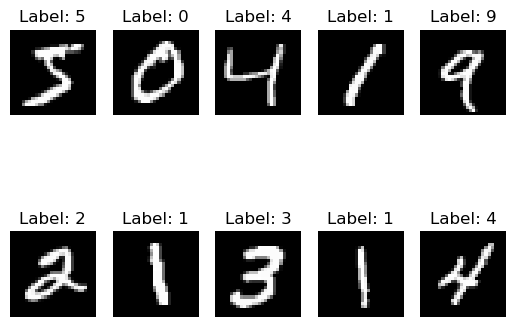

In [9]:
def plot_some_digits(image_data):
    X, y = mnist.data, mnist.target
    fig, axes = plt.subplots(nrows=2, ncols=5) # show 10 digits
    axes = axes.ravel() # flatten 2D-array to 1D-list for zip

    for ax, image, target in zip(axes, X[:10], y[:10]):
        image = image.reshape(28, 28) # reshape the feature vector
        ax.set_axis_off()
        ax.imshow(image, cmap='gray')
        ax.set_title(f'Label: {target}')
    plt.show()

plot_some_digits(mnist)

## Preprocessing

The database is clean, in the sense that all handwritten elements have been centered and preprocessed using different normalization algorithms. So we do not have to worry about doing exstensive preprocessing or formatting.

### Training and testing

Split data into a training set (60000 instances) and a test set (10000 instances). Instead of manually creating a validation set (X_val), I will let GridSearchCV handle cross-validation, and only keep a test set for final evaluation.

In [10]:
X_train, y_train = X[:60000], y[:60000]
X_test, y_test = X[60000:], y[60000:]

total_size = len(X)

# print sizes as percentages
print(f"Train: {len(X_train)} ({len(X_train) / total_size:.1%})")
print(f"Test: {len(X_test)} ({len(X_test) / total_size:.1%})")

Train: 60000 (85.7%)
Test: 10000 (14.3%)


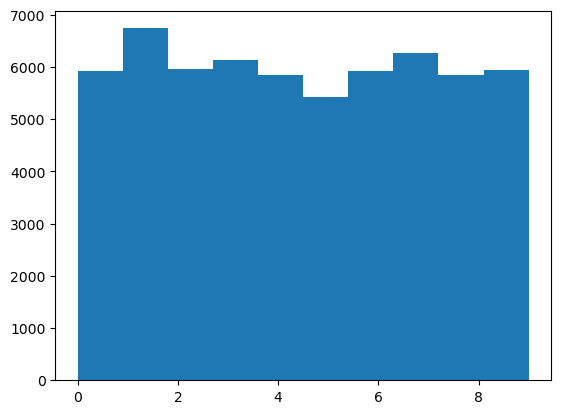

In [11]:
# are the labels balanced?
plt.hist(y_train)
plt.show()

The labels are balanced and are therefore suitable as training data.

## Data Augmentation

By creating four shifted copies (one per direction) and add them to the training I can articially grow the amount of training data.

In [12]:
from scipy.ndimage import shift

def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])


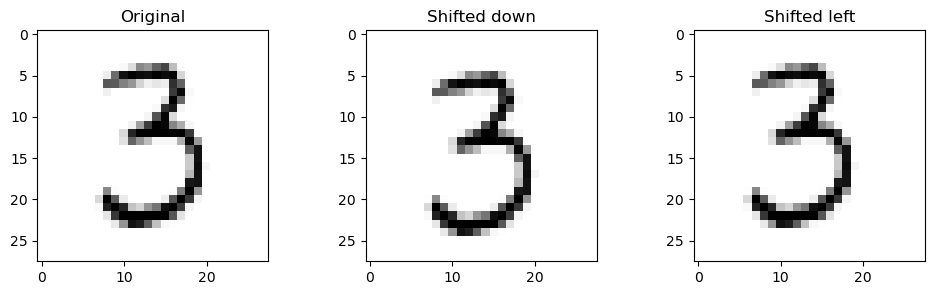

In [28]:
image = X_train[50]
shifted_image_down = shift_image(image, 0, 1)
shifted_image_left = shift_image(image, -1, 0)

plt.figure(figsize=(12, 3))
plt.subplot(131)
plt.title("Original")
plt.imshow(image.reshape(28, 28),
           interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted down")
plt.imshow(shifted_image_down.reshape(28, 28),
           interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted left")
plt.imshow(shifted_image_left.reshape(28, 28),
           interpolation="nearest", cmap="Greys")
plt.show()


Now let's create an augmented training set by shifting every image left, right, up and down by one pixel:

In [14]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((-1, 0), (1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

# shuffle augmented training set or else they will be grouped
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [15]:
extra_training_data = len(X_train_augmented) - len(X_train)
print(f'We got {extra_training_data} more training instances')

We got 240000 more training instances


## Select and train models

In this step we will also rescale our feature vectors. This is a very important step as it can increase the performance of the classifiers. This will be done in a Pipeline combining both a transformer and an estimator. Training will also be done on a smaller subset of the data in order to save time.

In [16]:
# create a smaller subset of the training data
subset_size = 10000  
X_train_sample = X_train_augmented[:subset_size]
y_train_sample = y_train_augmented[:subset_size]

In [17]:
# define classifiers
random_forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
knn_clf = KNeighborsClassifier()
xgb_clf = XGBClassifier(random_state=42, n_jobs=-1)

# create pipelines for each model with PCA and
estimators = {
    "Random Forest": Pipeline([
        ('scaler', StandardScaler()), 
        ('clf', random_forest_clf)
    ]),
    "KNN": Pipeline([
        ('scaler', StandardScaler()),
        ('clf', knn_clf)
    ]),
    "XGBoost": Pipeline([
        ('scaler', StandardScaler()),
        ('clf', xgb_clf)
    ])
}

# train and evaluate models
for name, pipeline in estimators.items():
    print(f"\nTraining {name} on {subset_size} samples...")
    pipeline.fit(X_train_sample, y_train_sample)
    score = pipeline.score(X_test, y_test)
    print(f"{name} Accuracy: {score:.4f}")



Training Random Forest on 10000 samples...
Random Forest Accuracy: 0.9512

Training KNN on 10000 samples...
KNN Accuracy: 0.9047

Training XGBoost on 10000 samples...
XGBoost Accuracy: 0.9613


XGBoost has the highest accuracy but Random Forest is not far away. Lets tune both  models in order to evalute performance.

## Hyperparameter tuning

In [ ]:
# define the Random Forest pipeline
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(random_state=42))
])

# hyperparameter space for tuning
param_grid = {
    'clf__n_estimators': [50, 100, 200],
    'clf__max_depth': [None, 10, 20, 30],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4]
}

# randomizedSearchCV for hyperparameter tuning
rf_search = RandomizedSearchCV(
    rf_pipeline, 
    param_grid, 
    n_iter=10,
    cv=3, 
    n_jobs=-1, 
    verbose=1,
    random_state=42
)

print("\n Tuning Random Forest with RandomizedSearchCV...")
rf_search.fit(X_train_sample, y_train_sample)

# best model
best_rf = rf_search.best_estimator_
print(f"Best Random Forest Params: {rf_search.best_params_}")
print(f"Best CV Accuracy: {rf_search.best_score_:.4f}")


 Tuning Random Forest with RandomizedSearchCV...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Random Forest Params: {'clf__n_estimators': 200, 'clf__min_samples_split': 2, 'clf__min_samples_leaf': 1, 'clf__max_depth': 30}
Best CV Accuracy: 0.9280


In [ ]:
# define the XGBoost pipeline
xgb_pipeline = Pipeline([
    ('scaler', StandardScaler()),  
    ('clf', XGBClassifier(
        objective='multi:softprob',  # output probability scores
        num_class=10,  # set number of classes
        eval_metric='mlogloss',
        random_state=42
    ))
])

# define hyperparameter search space
param_grid = {
    'clf__n_estimators': [50, 100, 200, 300],
    'clf__max_depth': [3, 6, 9],
    'clf__learning_rate': [0.01, 0.05, 0.1],
    'clf__subsample': [0.6, 0.8, 1.0],
    'clf__colsample_bytree': [0.6, 0.8, 1.0],
    'clf__reg_lambda': [0.001, 0.01, 1],  # L2 regularization
    'clf__reg_alpha': [0, 0.1, 0.5, 1]  # L1 regularization
}

# set up RandomizedSearchCV
xgb_search = RandomizedSearchCV(
    xgb_pipeline, 
    param_grid, 
    n_iter=10,
    cv=3,  
    n_jobs=-1,  
    verbose=1, 
    random_state=42
)

print("\nTuning XGBoost with RandomizedSearchCV")
xgb_search.fit(X_train_sample, y_train_sample)

# best model and results
best_xgb = xgb_search.best_estimator_
print(f"Best XGBoost Params: {xgb_search.best_params_}")
print(f"Best CV Accuracy: {xgb_search.best_score_:.4f}")


Tuning XGBoost with RandomizedSearchCV (multi:softprob)...
Fitting 3 folds for each of 10 candidates, totalling 30 fits


Best XGBoost Params: {'clf__subsample': 1.0, 'clf__reg_lambda': 0.01, 'clf__reg_alpha': 0.1, 'clf__n_estimators': 300, 'clf__max_depth': 6, 'clf__learning_rate': 0.1, 'clf__colsample_bytree': 0.6}
Best CV Accuracy: 0.9322


XGBClassifier has the highest cross-validation score and will thus be our final model choice.

### Estimate test accuracy by retraining the best model (the XGBClassifier) on the full dataset

This is the last step before deploying our model for real-world predictions.

In [25]:
# define the final pipeline
final_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', best_xgb)
])

print("\n Retraining the Best Model on the Full Training Dataset...")

# train the pipeline on the full training data
final_pipeline.fit(X_train_augmented, y_train_augmented)

# make probability predictions
y_proba = final_pipeline.predict_proba(X_test)  # outputs class probabilities

# convert probabilities to class labels
y_pred = y_proba.argmax(axis=1)  # select the class with the highest probability

# compute final test accuracy
final_xgb_accuracy = accuracy_score(y_test, y_pred)
print(f"\n Final XGBoost Test Accuracy: {final_xgb_accuracy:.4f}")


 Retraining the Best Model on the Full Training Dataset...

 Final XGBoost Test Accuracy: 0.9858


We reached our goal and the final classification accuracy on the test set is 98.58%!

### Error analysis

In [26]:
from sklearn.metrics import classification_report

print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.98      0.99       982
           5       0.99      0.98      0.99       892
           6       0.99      0.98      0.99       958
           7       0.99      0.98      0.98      1028
           8       0.98      0.99      0.98       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



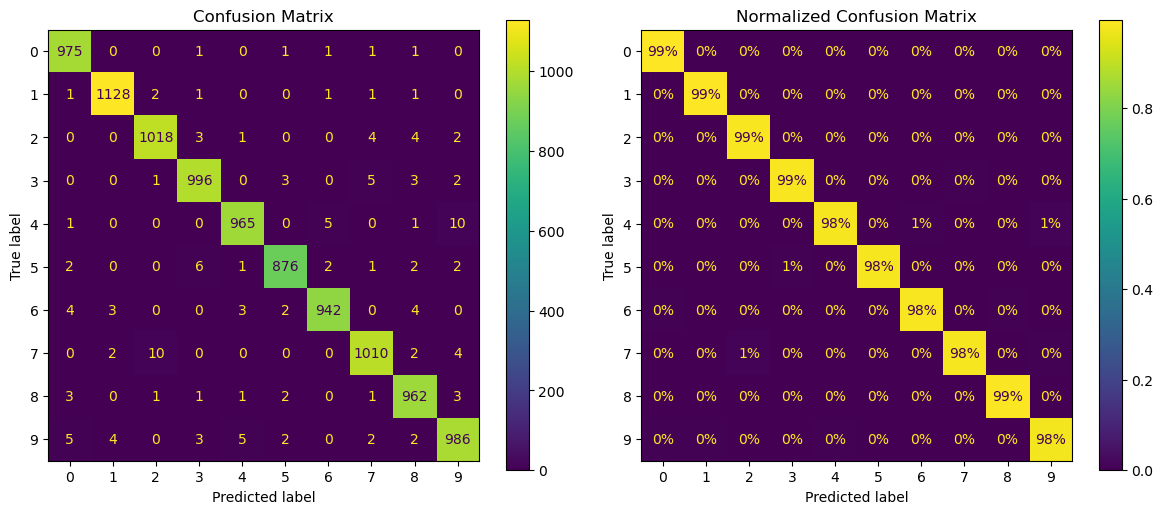

In [27]:
# create subplots for side-by-side visualization
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))  # Adjust figure size

# standard Confusion Matrix
plt.sca(axs[0])  # Set active subplot
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=axs[0])
axs[0].set_title("Confusion Matrix")

# normalized Confusion Matrix
plt.sca(axs[1])
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize="true", values_format=".0%", ax=axs[1])
axs[1].set_title("Normalized Confusion Matrix")

plt.tight_layout()
plt.show()

This confusion matrix looks good, the model seem to struggle a little bit with identifying 5's as 3's (and vice versa), which is not suprising as they share similar visual features.

### Save the Model Pipeline

In [ ]:
import joblib

# save the final model (only the learned parameters)
joblib.dump(final_pipeline, "final_xgb_model.pkl", compress=3)

['final_xgb_model.pkl']